a

In [24]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


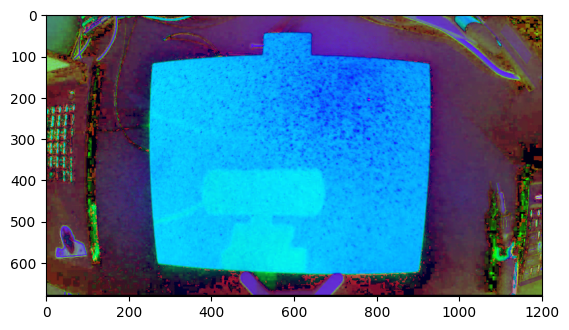

In [26]:
data_name = "Base.png"
data_folder = os.path.join(os.getcwd(), "TestData")
bgr = cv2.imread(os.path.join(data_folder, data_name))
original_bgr = bgr.copy()
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

plt.imshow(hsv)

In [27]:
lower_red1 = np.array([0, 120, 70])   
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = mask1 | mask2

# --- Morphological operations to reduce noise ---
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# --- Find contours in the mask ---
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) == 0:
    print("No red object detected.")
else:
    print(f"{len(contours)} contours detected")

24 contours detected


In [28]:
contours = sorted(contours, key=cv2.contourArea, reverse=True)
c = contours[0]
epsilon = 0.05 * cv2.arcLength(c, True)  # Tweak the factor 0.02 for more/less precision
approx = cv2.approxPolyDP(c, epsilon, True)
if len(approx) != 4:
    print(f"Warning: Expected 4 corners, but got {len(approx)}. "
          "You may need to adjust the approximation threshold.")




Center of the warped image: (93, 70)


(-0.5, 186.5, 140.5, -0.5)

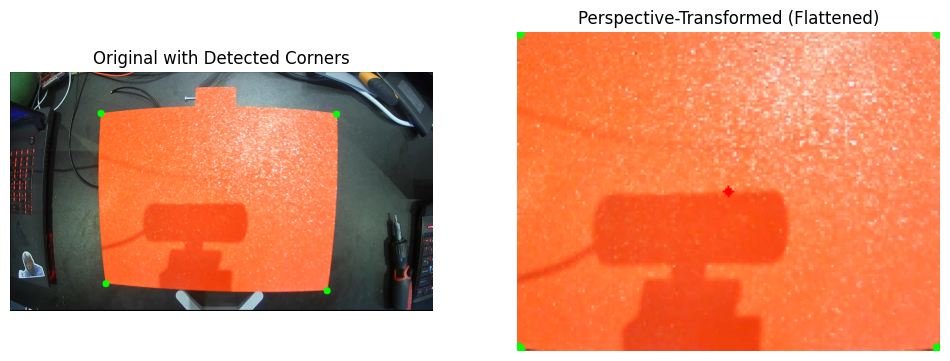

In [31]:
pts = approx.reshape(-1, 2)

def order_points(pts):
    # pts: array of shape (4, 2)
    # Returns: array of shape (4, 2) in the order:
    #          top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    
    rect[0] = pts[np.argmin(s)]    # top-left
    rect[2] = pts[np.argmax(s)]     # bottom-right
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

ordered_pts = order_points(pts)

# Define desired output dimensions for the warped image
W = 187
H = 141
dst_pts = np.array([
    [0,     0],
    [W - 1, 0],
    [W - 1, H - 1],
    [0,     H - 1]
], dtype="float32")

# Compute the perspective transform matrix and apply it
M = cv2.getPerspectiveTransform(ordered_pts, dst_pts)
warped = cv2.warpPerspective(original_bgr, M, (W, H))

# Mark detected corners on the original image
for pt in pts:
    cv2.circle(original_bgr, tuple(pt), 10, (0, 255, 0), -1)

# Calculate the center (middle) of the warped image
center_x = W // 2
center_y = H // 2
center_point = (center_x, center_y)

# Mark the center on the warped image with a red circle
cv2.circle(warped, center_point, 2, (0, 0, 255), -1)

# Print the center coordinates
print(f"Center of the warped image: {center_point}")

# Convert images from BGR to RGB for displaying with matplotlib
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
warped_rgb   = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

# Create a figure with a specified size
plt.figure(figsize=(12, 6))

# Plot the original image with detected corners
plt.subplot(1, 2, 1)
plt.imshow(original_rgb)
plt.title("Original with Detected Corners")
plt.axis('off')

# Plot the perspective-transformed (flattened) image with center marked
plt.subplot(1, 2, 2)
plt.imshow(warped_rgb)
plt.title("Perspective-Transformed (Flattened)")
plt.axis('off')